# image adjustments

In [36]:
%matplotlib inline

## color model conversions
- RGB (red,green,blue); HSV (hue,sat,value); CMYK (for printing)

In [12]:
import numpy as np
import skimage.color as color

In [14]:
red_pixel_rgb       = np.array([[[255,   0,   0]]], dtype=np.uint8)
dark_blue_pixel_rgb = np.array([[[  0,   0, 100]]], dtype=np.uint8)
pink_pixel_rgb      = np.array([[[255, 100, 255]]], dtype=np.uint8)

print(color.rgb2hsv(red_pixel_rgb))
print(color.rgb2hsv(dark_blue_pixel_rgb))
print(color.rgb2hsv(pink_pixel_rgb))

[[[0. 1. 1.]]]
[[[0.66666667 1.         0.39215686]]]
[[[0.83333333 0.60784314 1.        ]]]


In [16]:
# RGBA to RGB (removes alpha channel)

from skimage.color import rgba2rgb
from skimage import data
img_rgba = data.logo()
img_rgb  = rgba2rgb(img_rgba)
img_rgb.shape

(500, 500, 3)

In [23]:
# RGB to grayscale
# non-uniform channel weighting due to different eye sensitivities;
# ensures luminance preservation

red_pixel   = np.array([[[255, 0, 0]]], dtype=np.uint8)
green_pixel = np.array([[[0, 255, 0]]], dtype=np.uint8)

print(color.rgb2gray(red_pixel))
print(color.rgb2gray(green_pixel))

[[0.2125]]
[[0.7154]]


In [22]:
# grayscale to RGB: just copies gray across channels
graypixel = color.rgb2gray(red_pixel)
#print(color.gray2rgb(graypixel)) # bugged

In [27]:
# invert image

from skimage import util
img = data.camera()
inverted_img = util.invert(img)
inverted_img.shape, inverted_img.dtype

((512, 512), dtype('uint8'))

## paint images with labels

### tinting grayscale images

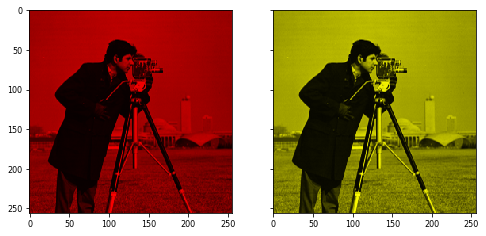

In [41]:
import matplotlib.pyplot as plt
from skimage import data
from skimage import color
from skimage import img_as_float

grayscale_image = img_as_float(data.camera()[::2, ::2])
image = color.gray2rgb(grayscale_image)

red_multiplier = [1, 0, 0]
yellow_multiplier = [1, 1, 0]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4),
                               sharex=True, sharey=True)
ax1.imshow(red_multiplier * image)
ax2.imshow(yellow_multiplier * image)

### intersection of two segments
- computes the __join__ of 2 segments

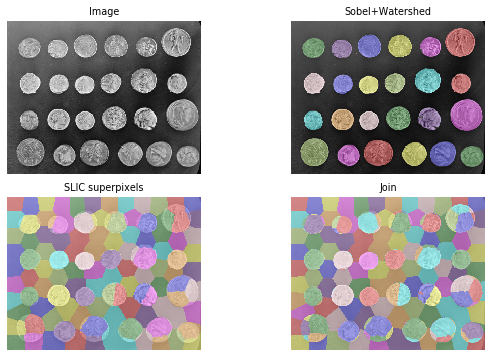

In [40]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.filters import sobel
from skimage.measure import label
from skimage.segmentation import slic, join_segmentations
from skimage.morphology import watershed
from skimage.color import label2rgb
from skimage import data

coins = data.coins()

# Make segmentation using edge-detection and watershed.
edges = sobel(coins)

# Identify some background and foreground pixels from the intensity values.
# These pixels are used as seeds for watershed.
markers = np.zeros_like(coins)
foreground, background = 1, 2

markers[coins < 30.0] = background
markers[coins > 150.0] = foreground

ws = watershed(edges, markers)
seg1 = label(ws == foreground)

# Make segmentation using SLIC superpixels.
seg2 = slic(
    coins, 
    n_segments=117, 
    max_iter=160, 
    sigma=1, 
    compactness=0.75,
    multichannel=False)

# Combine the two.
segj = join_segmentations(seg1, seg2)

# Show the segmentations.
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(9, 5),
                         sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(coins, cmap='gray')
ax[0].set_title('Image')

color1 = label2rgb(seg1, image=coins, bg_label=0)
ax[1].imshow(color1)
ax[1].set_title('Sobel+Watershed')

color2 = label2rgb(seg2, image=coins, image_alpha=0.5)
ax[2].imshow(color2)
ax[2].set_title('SLIC superpixels')

color3 = label2rgb(segj, image=coins, image_alpha=0.5)
ax[3].imshow(color3)
ax[3].set_title('Join')

for a in ax:
    a.axis('off')
    
fig.tight_layout()
plt.show()

### RAG thresholding
- builds __region adjacency graph__ & merges similar regions
- edges defined as difference in mean color.

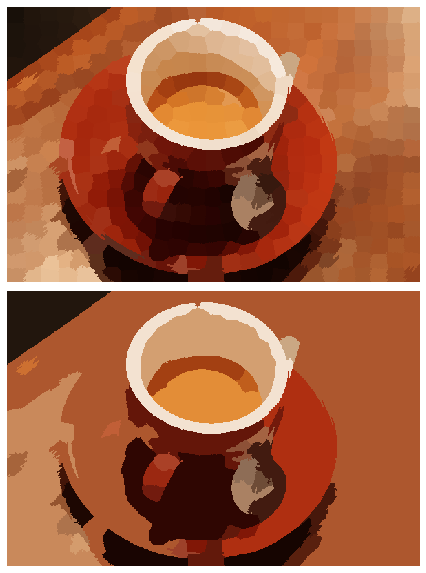

In [39]:
from skimage import data, io, segmentation, color
from skimage.future import graph
from matplotlib import pyplot as plt

img = data.coffee()

labels1 = segmentation.slic(img, compactness=30, n_segments=400)
g       = graph.rag_mean_color(img, labels1)
labels2 = graph.cut_threshold(labels1, g, 29)
out1    = color.label2rgb(labels1, img, kind='avg')
out2    = color.label2rgb(labels2, img, kind='avg')

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True,
                       figsize=(6, 8))

ax[0].imshow(out1)
ax[1].imshow(out2)

for a in ax:
    a.axis('off')

plt.tight_layout()

## contrast, exposure
- most images have narrow range of pixel values (by dtype)
- causes: poor contrast, or concentrated in a subrange.

In [29]:
import skimage.exposure as exposure

In [30]:
# histogram - returns #pixels for each bin + bin centers

image = np.array([[1,3],[1,1]])
exposure.histogram(image)

(array([3, 0, 1]), array([1, 2, 3]))

In [32]:
# rescale intensity - stretches pixel values out to range, linearly

text = data.text()
print(text.min(), text.max())

better_contrast = exposure.rescale_intensity(text)
print(better_contrast.min(), better_contrast.max())

10 197
0 255


In [33]:
# clipping

moon = data.moon()
v_min, v_max = np.percentile(moon, (0.2, 99.8))
print(v_min, v_max)

better_contrast = exposure.rescale_intensity(moon, in_range=(v_min,v_max))
print(better_contrast.min(), better_contrast.max())

10.0 186.0
0 255


### histogram equalization
- enhances low-contrast images
- "spreads out" most frequent intensity values.
- result image has rough linear cume distribution function
- "contrast stretching" - rescales images to 2nd & 98th percentiles.

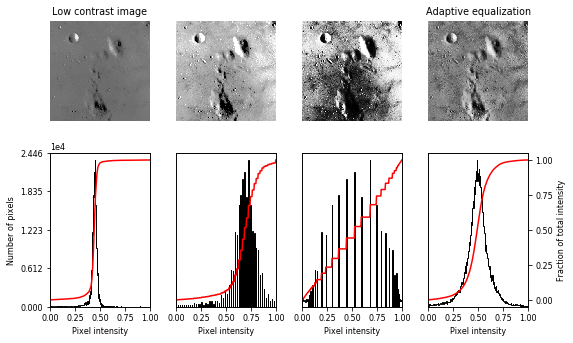

In [38]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data, img_as_float
from skimage import exposure


matplotlib.rcParams['font.size'] = 8


def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


# Load an example image
img = data.moon()

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)


ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])

ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()

ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])

ax_img.set_title('Contrast stretching')
ax_img.set_title('Histogram equalization')
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()